# 2018-05-14 - Test feedforward, unsync, lateral avec 16 thetas 
# Feedforward

In [1]:
%matplotlib inline
import pickle

Images en 64x64 parce que le 32x32 est trop aliasé pour que le network puisse apprendre :

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=16, shuffle=True,
                                             num_workers=1)

test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=16,shuffle=False,
                                             num_workers=1)

On affiche des images du set importé pour vérifier que tout a bien marché :

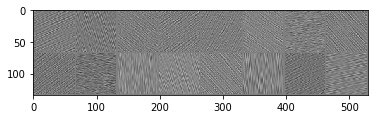

In [3]:
import matplotlib.pyplot as plt
import numpy as np


# pour montrer une image
def imshow(img):
    img = img / 2 + 0.5    #de-normaliser
    npimg = img.numpy()    #convertir en array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# on loop sur un batch
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))


Réseau à trois couches :

In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(64*64,1000)
            self.fc2 = nn.Linear(1000, 200)
            self.fc3 = nn.Linear(200, 16)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=4096, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=16, bias=True)
)


Et l'optimiseur, toujours en SGD mais avec un learning rate 10 fois plus grand. Avec NLLL comme critère, on a rajouté une couche de softmax en sortie pour obtenir des log-proba.

In [5]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

On entraine :

In [6]:
import time
start_time = time.time()
print("Started training")

epochs = 50
print_interval = 50 #prints every p_i*4
tempo = []
acc = []

for epoch in range(epochs):  # nbr epochs
    for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
        data, target = Variable(data), Variable(target)
        
        #On resize pour la sortie
        data = data.view(-1, 64*64)

        #init l'entrainement
        optimizer.zero_grad()
        net_out = model(data)

        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()

        #afficher la progression
        if batch_idx % print_interval == 0:
            #le print statement le plus illisible du monde
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    tempo.append(epoch)
    acc.append(loss.data[0])
    
print("Finished training in  %.3f seconds " % (time.time() - start_time))

Started training
Epoch: 1 [0/1920 (0%)]	Loss: 2.783000


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 [800/1920 (42%)]	Loss: 2.788995
Epoch: 1 [1600/1920 (83%)]	Loss: 2.774750


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 2 [0/1920 (0%)]	Loss: 2.771770
Epoch: 2 [800/1920 (42%)]	Loss: 2.766619
Epoch: 2 [1600/1920 (83%)]	Loss: 2.770617
Epoch: 3 [0/1920 (0%)]	Loss: 2.740508
Epoch: 3 [800/1920 (42%)]	Loss: 2.749232
Epoch: 3 [1600/1920 (83%)]	Loss: 2.726201
Epoch: 4 [0/1920 (0%)]	Loss: 2.691997
Epoch: 4 [800/1920 (42%)]	Loss: 2.707187
Epoch: 4 [1600/1920 (83%)]	Loss: 2.689682
Epoch: 5 [0/1920 (0%)]	Loss: 2.613953
Epoch: 5 [800/1920 (42%)]	Loss: 2.653799
Epoch: 5 [1600/1920 (83%)]	Loss: 2.596183
Epoch: 6 [0/1920 (0%)]	Loss: 2.411430
Epoch: 6 [800/1920 (42%)]	Loss: 2.388200
Epoch: 6 [1600/1920 (83%)]	Loss: 2.110333
Epoch: 7 [0/1920 (0%)]	Loss: 1.876800
Epoch: 7 [800/1920 (42%)]	Loss: 1.683356
Epoch: 7 [1600/1920 (83%)]	Loss: 1.245901
Epoch: 8 [0/1920 (0%)]	Loss: 0.721138
Epoch: 8 [800/1920 (42%)]	Loss: 0.759403
Epoch: 8 [1600/1920 (83%)]	Loss: 0.749685
Epoch: 9 [0/1920 (0%)]	Loss: 0.212468
Epoch: 9 [800/1920 (42%)]	Loss: 0.141943
Epoch: 9 [1600/1920 (83%)]	Loss: 0.133719
Epoch: 10 [0/1920 (0%)]	Loss: 0.

Et maintenant on teste :

In [7]:
test_loss = 0
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    
    #rescale
    data = data.view(-1, 64 * 64)
    net_out = model(data)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.1796, Accuracy: 82/192 (42%)



/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


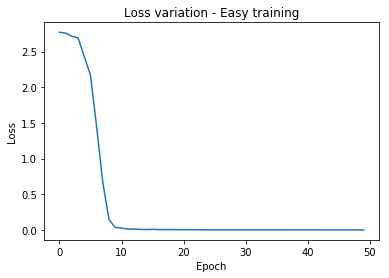

In [8]:
#joli plot du loss en fonction de l'epoch
import matplotlib.pyplot as plt
plt.plot(tempo, acc)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss variation - Easy training')
plt.savefig('mc16easy_sync.png')
plt.show()

torch.save(model.state_dict(), "MODEL_forward_sync_16thetas")

# Unsync learning - linear
Layer par layer donc, comme lors de l'ajout du L2 sur CHAMP :

In [9]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=16, shuffle=True,
                                             num_workers=1)

test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=16,shuffle=False,
                                             num_workers=1)

Le même network qu'en forward classique :

In [10]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(64*64,1000)
            self.fc2 = nn.Linear(1000, 200)
            self.fc3 = nn.Linear(200, 16)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=4096, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=16, bias=True)
)


On modifie les flags du réseau pour n'entrainer qu'un seul layer :

In [11]:
#freeze layers after and including freezing_layer+1 (layers start at 0)
def freeze_layers(freezing_layer, nn_model = model) :
    for count,child in enumerate(model.children()) :
        if count < freezing_layer+1 : #to freeze at iteration 1
            print("Layer no. %s -- %s -- NOT FROZEN"% (count,child))
            for param in child.parameters():
                param.requires_grad = True
        else :
            print("Layer no. %s -- %s -- FROZEN"%(count, child))
            for param in child.parameters():
                param.requires_grad = False

#freeze all the layers except the unfrozen one
def freeze_all_layers(unfrozen_layer, nn_model = model) :
    for count,child in enumerate(model.children()) :
        if count == unfrozen_layer :
            print("Layer no. %s -- %s -- NOT FROZEN"% (count,child))
            for param in child.parameters():
                param.requires_grad = True
        else :
            print("Layer no. %s -- %s -- FROZEN"%(count, child))
            for param in child.parameters():
                param.requires_grad = False

#unfreeze every layers
def layers_microwave(nn_model = model) :
    for count,child in enumerate(model.children()) :
        for param in child.parameters():
            param.requires_grad = True

In [12]:
import torch.optim as optim
import time

#unfreeze before starting
layers_microwave(model)

criterion = nn.NLLLoss() #loss criterion
epochs = 20 #nbr of epochs per layer
model_size = 3 #nbr of layers

print_interval = 50 #prints every p_i*4
tempo = []
acc = []

start_time = time.time()
print("Started training")


#################
#Loop over layers
################
for layer in range(model_size) :
    freeze_all_layers(layer, model)
    optimizer = optim.SGD(filter(lambda p : p.requires_grad, model.parameters()), #optimize only on requires_grad layers
                      lr=0.01, momentum=0.9)
    
    #################
    #Loop over epochs
    ################
    for epoch in range(epochs):  # nbr epochs
        for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
            data, target = Variable(data), Variable(target)

            #On resize pour la sortie
            data = data.view(-1, 64*64)

            #init l'entrainement
            optimizer.zero_grad()
            net_out = model(data)

            loss = criterion(net_out, target)
            loss.backward()
            optimizer.step()

            #afficher la progression
            if batch_idx % print_interval == 0:
                #le print statement le plus illisible du monde
                print('Epoch: {} [{}/{} ({:.0f}%)]\t\tLoss: {:.6f}'.format(
                        epoch+1, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.data[0]))
        tempo.append(epoch)
        acc.append(loss.data[0])



print("Finished training in  %.3f seconds " % (time.time() - start_time))

Started training
Layer no. 0 -- Linear(in_features=4096, out_features=1000, bias=True) -- NOT FROZEN
Layer no. 1 -- Linear(in_features=1000, out_features=200, bias=True) -- FROZEN
Layer no. 2 -- Linear(in_features=200, out_features=16, bias=True) -- FROZEN
Epoch: 1 [0/1920 (0%)]		Loss: 2.775549


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 [800/1920 (42%)]		Loss: 2.771909
Epoch: 1 [1600/1920 (83%)]		Loss: 2.767349


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 2 [0/1920 (0%)]		Loss: 2.758564
Epoch: 2 [800/1920 (42%)]		Loss: 2.752814
Epoch: 2 [1600/1920 (83%)]		Loss: 2.749314
Epoch: 3 [0/1920 (0%)]		Loss: 2.758724
Epoch: 3 [800/1920 (42%)]		Loss: 2.756388
Epoch: 3 [1600/1920 (83%)]		Loss: 2.754797
Epoch: 4 [0/1920 (0%)]		Loss: 2.734277
Epoch: 4 [800/1920 (42%)]		Loss: 2.740221
Epoch: 4 [1600/1920 (83%)]		Loss: 2.749723
Epoch: 5 [0/1920 (0%)]		Loss: 2.735219
Epoch: 5 [800/1920 (42%)]		Loss: 2.717625
Epoch: 5 [1600/1920 (83%)]		Loss: 2.712236
Epoch: 6 [0/1920 (0%)]		Loss: 2.721846
Epoch: 6 [800/1920 (42%)]		Loss: 2.722898
Epoch: 6 [1600/1920 (83%)]		Loss: 2.694740
Epoch: 7 [0/1920 (0%)]		Loss: 2.707570
Epoch: 7 [800/1920 (42%)]		Loss: 2.675488
Epoch: 7 [1600/1920 (83%)]		Loss: 2.682980
Epoch: 8 [0/1920 (0%)]		Loss: 2.693843
Epoch: 8 [800/1920 (42%)]		Loss: 2.679813
Epoch: 8 [1600/1920 (83%)]		Loss: 2.671509
Epoch: 9 [0/1920 (0%)]		Loss: 2.661609
Epoch: 9 [800/1920 (42%)]		Loss: 2.688611
Epoch: 9 [1600/1920 (83%)]		Loss: 2.652831
Epoch: 1

In [13]:
test_loss = 0
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    
    #rescale
    data = data.view(-1, 64 * 64)
    net_out = model(data)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.2373, Accuracy: 74/192 (38%)



/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


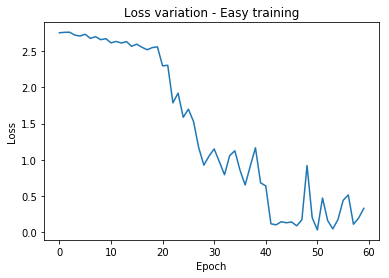

In [14]:
#stupid fix for stupid error
tempo2=[]
for x in range(len(tempo)) :
    tempo2.append(x)

#joli plot du loss en fonction de l'epoch
import matplotlib.pyplot as plt
plt.plot(tempo2, acc)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss variation - Easy training')
plt.savefig('mc16easy_unsync.png')
plt.show()

torch.save(model.state_dict(), "MODEL_forward_usync_16thetas")

# Unsync learning - Convolutional
/!\ GPU-vore

Faire attention au loss, en crossentropy ici et pas en NLLL comme avant.

Réseau convolutionnel à une couche avec une relu et une fully connected derrière :

In [15]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=6, shuffle=True,
                                             num_workers=1, drop_last = True)

#test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=6,shuffle=False,
                                             num_workers=1, drop_last = True)

In [16]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 20)
        self.pool = nn.MaxPool2d(2,2)

        self.fc3 = nn.Linear(17496,1000)

        self.outlayer = nn.Linear(1000,16)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))

        x = x.view(x.size(0), -1) #reshape from conv to linear

        x = F.leaky_relu(self.fc3(x))

        x = self.outlayer(x)
        return x
        
model = Net()
model = model.cuda()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(20, 20), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc3): Linear(in_features=17496, out_features=1000, bias=True)
  (outlayer): Linear(in_features=1000, out_features=16, bias=True)
)


In [17]:
#freeze layers after and including freezing_layer+1 (layers start at 0)
def freeze_layers(freezing_layer, nn_model = model) :
    for count,child in enumerate(model.children()) :
        if count < freezing_layer+1 : #to freeze at iteration 1
            print("Layer no. %s -- %s -- NOT FROZEN"% (count,child))
            for param in child.parameters():
                param.requires_grad = True
        else :
            print("Layer no. %s -- %s -- FROZEN"%(count, child))
            for param in child.parameters():
                param.requires_grad = False

#freeze all the layers except the unfrozen one
def freeze_all_layers(unfrozen_layer, nn_model = model) :
    for count,child in enumerate(model.children()) :
        if count == unfrozen_layer :
            print("Layer no. %s -- %s -- NOT FROZEN"% (count,child))
            for param in child.parameters():
                param.requires_grad = True
        else :
            print("Layer no. %s -- %s -- FROZEN"%(count, child))
            for param in child.parameters():
                param.requires_grad = False

#unfreeze every layers
def layers_microwave(nn_model = model) :
    for count,child in enumerate(model.children()) :
        for param in child.parameters():
            param.requires_grad = True

In [18]:
import torch.optim as optim
import time

#unfreeze before starting
layers_microwave(model)

criterion = nn.CrossEntropyLoss() #loss criterion
epochs = 5 #nbr of epochs per layer
model_size = 4 #nbr of layers

print_interval = 50 #prints every p_i*4
tempo = []
acc = []

start_time = time.time()
print("Started training")


#################
#Loop over layers
################
for layer in range(model_size) :
    if layer!= 1 : #dont want to freeze maxpool2D
        freeze_all_layers(layer, model)
        optimizer = optim.SGD(filter(lambda p : p.requires_grad, model.parameters()), #optimize only on requires_grad layers
                          lr=0.001, momentum=0.9)

        #################
        #Loop over epochs
        ################
        for epoch in range(epochs):  # nbr epochs
            for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
                data, target = Variable(data), Variable(target)
                data, target = data.cuda(), target.cuda()
                #On resize pour la sortie


                #init l'entrainement
                optimizer.zero_grad()
                net_out = model(data)

                loss = criterion(net_out, target)
                loss.backward()
                optimizer.step()

                #afficher la progression
                if batch_idx % print_interval == 0:
                    #le print statement le plus illisible du monde
                    print('Epoch: {} [{}/{} ({:.0f}%)]\t\tLoss: {:.6f}'.format(
                            epoch+1, batch_idx * len(data), len(train_loader.dataset),
                            100. * batch_idx / len(train_loader), loss.data[0]))
            tempo.append(epoch)
            acc.append(loss.data[0])
    else:
        pass


print("Finished training in  %.3f seconds " % (time.time() - start_time))

Started training
Layer no. 0 -- Conv2d(1, 6, kernel_size=(20, 20), stride=(1, 1)) -- NOT FROZEN
Layer no. 1 -- MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) -- FROZEN
Layer no. 2 -- Linear(in_features=17496, out_features=1000, bias=True) -- FROZEN
Layer no. 3 -- Linear(in_features=1000, out_features=16, bias=True) -- FROZEN
Epoch: 1 [0/1920 (0%)]		Loss: 2.786464


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 [300/1920 (16%)]		Loss: 2.784435
Epoch: 1 [600/1920 (31%)]		Loss: 2.784626
Epoch: 1 [900/1920 (47%)]		Loss: 2.781821
Epoch: 1 [1200/1920 (62%)]		Loss: 2.775539
Epoch: 1 [1500/1920 (78%)]		Loss: 2.770079
Epoch: 1 [1800/1920 (94%)]		Loss: 2.779841


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 2 [0/1920 (0%)]		Loss: 2.761690
Epoch: 2 [300/1920 (16%)]		Loss: 2.770029
Epoch: 2 [600/1920 (31%)]		Loss: 2.766756
Epoch: 2 [900/1920 (47%)]		Loss: 2.746294
Epoch: 2 [1200/1920 (62%)]		Loss: 2.770546
Epoch: 2 [1500/1920 (78%)]		Loss: 2.758783
Epoch: 2 [1800/1920 (94%)]		Loss: 2.769866
Epoch: 3 [0/1920 (0%)]		Loss: 2.762842
Epoch: 3 [300/1920 (16%)]		Loss: 2.771000
Epoch: 3 [600/1920 (31%)]		Loss: 2.760007
Epoch: 3 [900/1920 (47%)]		Loss: 2.767130
Epoch: 3 [1200/1920 (62%)]		Loss: 2.759622
Epoch: 3 [1500/1920 (78%)]		Loss: 2.746916
Epoch: 3 [1800/1920 (94%)]		Loss: 2.789264
Epoch: 4 [0/1920 (0%)]		Loss: 2.766648
Epoch: 4 [300/1920 (16%)]		Loss: 2.761686
Epoch: 4 [600/1920 (31%)]		Loss: 2.783696
Epoch: 4 [900/1920 (47%)]		Loss: 2.754333
Epoch: 4 [1200/1920 (62%)]		Loss: 2.775169
Epoch: 4 [1500/1920 (78%)]		Loss: 2.766687
Epoch: 4 [1800/1920 (94%)]		Loss: 2.772899
Epoch: 5 [0/1920 (0%)]		Loss: 2.744859
Epoch: 5 [300/1920 (16%)]		Loss: 2.769528
Epoch: 5 [600/1920 (31%)]		Loss: 2.77

In [19]:
test_loss = 0
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    data, target = data.cuda(), target.cuda()


    net_out = model(data)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':



Test set: Average loss: 0.1076, Accuracy: 150/192 (78%)



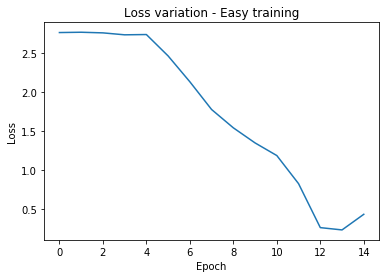

In [20]:
import matplotlib.pyplot as plt

#stupid fix for stupid error
tempo2=[]
for x in range(len(tempo)) :
    tempo2.append(x)
    
#joli plot du loss en fonction de l'epoch

plt.plot(tempo2, acc)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss variation - Easy training')
plt.savefig('mc16easy_unsync_convo.png')
plt.show()

torch.save(model.state_dict(), "MODEL_convo_unsync_16thetas")

Maintenant le convo synchro pour faire une comparaison :

In [21]:
import time
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=6, shuffle=True,
                                             num_workers=1, drop_last = True)

#test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=6,shuffle=False,
                                             num_workers=1, drop_last = True)





from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 20)
        self.pool = nn.MaxPool2d(2,2)

        self.fc3 = nn.Linear(17496,1000)

        self.outlayer = nn.Linear(1000,16)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))

        x = x.view(x.size(0), -1) #reshape from conv to linear

        x = F.leaky_relu(self.fc3(x))

        x = self.outlayer(x)
        return x
        
model_sync = Net()
model_sync = model_sync.cuda()
print(model_sync)




layers_microwave(model_sync)
criterion = nn.CrossEntropyLoss() #loss criterion
optimizer = optim.SGD(model_sync.parameters(), lr=0.01, momentum=0.9)

start_time = time.time()
print("Started training")

epochs = 50
print_interval = 50 #prints every p_i*4
tempo = []
acc = []

for epoch in range(epochs):  # nbr epochs
    for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
        data, target = Variable(data), Variable(target)
        data, target = data.cuda(), target.cuda()


        #init l'entrainement
        optimizer.zero_grad()
        net_out = model_sync(data)

        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()

        #afficher la progression
        if batch_idx % print_interval == 0:
            #le print statement le plus illisible du monde
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    tempo.append(epoch)
    acc.append(loss.data[0])
    
print("Finished training in  %.3f seconds " % (time.time() - start_time))

Net(
  (conv1): Conv2d(1, 6, kernel_size=(20, 20), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc3): Linear(in_features=17496, out_features=1000, bias=True)
  (outlayer): Linear(in_features=1000, out_features=16, bias=True)
)
Started training
Epoch: 1 [0/1920 (0%)]	Loss: 2.785182


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 [300/1920 (16%)]	Loss: 2.209259
Epoch: 1 [600/1920 (31%)]	Loss: 1.948500
Epoch: 1 [900/1920 (47%)]	Loss: 1.700166
Epoch: 1 [1200/1920 (62%)]	Loss: 1.957314
Epoch: 1 [1500/1920 (78%)]	Loss: 1.340614
Epoch: 1 [1800/1920 (94%)]	Loss: 3.139251


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 2 [0/1920 (0%)]	Loss: 0.881710
Epoch: 2 [300/1920 (16%)]	Loss: 2.244890
Epoch: 2 [600/1920 (31%)]	Loss: 1.951094
Epoch: 2 [900/1920 (47%)]	Loss: 1.476372
Epoch: 2 [1200/1920 (62%)]	Loss: 1.257081
Epoch: 2 [1500/1920 (78%)]	Loss: 2.887911
Epoch: 2 [1800/1920 (94%)]	Loss: 1.720515
Epoch: 3 [0/1920 (0%)]	Loss: 1.623006
Epoch: 3 [300/1920 (16%)]	Loss: 2.130487
Epoch: 3 [600/1920 (31%)]	Loss: 1.438382
Epoch: 3 [900/1920 (47%)]	Loss: 1.564095
Epoch: 3 [1200/1920 (62%)]	Loss: 1.201107
Epoch: 3 [1500/1920 (78%)]	Loss: 2.233534
Epoch: 3 [1800/1920 (94%)]	Loss: 1.625189
Epoch: 4 [0/1920 (0%)]	Loss: 0.947628
Epoch: 4 [300/1920 (16%)]	Loss: 1.283885
Epoch: 4 [600/1920 (31%)]	Loss: 1.408474
Epoch: 4 [900/1920 (47%)]	Loss: 0.873807
Epoch: 4 [1200/1920 (62%)]	Loss: 0.639008
Epoch: 4 [1500/1920 (78%)]	Loss: 0.410620
Epoch: 4 [1800/1920 (94%)]	Loss: 1.754026
Epoch: 5 [0/1920 (0%)]	Loss: 0.102560
Epoch: 5 [300/1920 (16%)]	Loss: 0.361438
Epoch: 5 [600/1920 (31%)]	Loss: 0.753790
Epoch: 5 [900/1920 

Epoch: 30 [300/1920 (16%)]	Loss: 0.000590
Epoch: 30 [600/1920 (31%)]	Loss: 0.000088
Epoch: 30 [900/1920 (47%)]	Loss: 0.001210
Epoch: 30 [1200/1920 (62%)]	Loss: 0.000035
Epoch: 30 [1500/1920 (78%)]	Loss: 0.022620
Epoch: 30 [1800/1920 (94%)]	Loss: 0.010871
Epoch: 31 [0/1920 (0%)]	Loss: 0.033249
Epoch: 31 [300/1920 (16%)]	Loss: 0.000391
Epoch: 31 [600/1920 (31%)]	Loss: 0.038335
Epoch: 31 [900/1920 (47%)]	Loss: 0.008436
Epoch: 31 [1200/1920 (62%)]	Loss: 0.000609
Epoch: 31 [1500/1920 (78%)]	Loss: 0.004240
Epoch: 31 [1800/1920 (94%)]	Loss: 0.004098
Epoch: 32 [0/1920 (0%)]	Loss: 0.003703
Epoch: 32 [300/1920 (16%)]	Loss: 0.004299
Epoch: 32 [600/1920 (31%)]	Loss: 0.001296
Epoch: 32 [900/1920 (47%)]	Loss: 0.002191
Epoch: 32 [1200/1920 (62%)]	Loss: 0.000615
Epoch: 32 [1500/1920 (78%)]	Loss: 0.026650
Epoch: 32 [1800/1920 (94%)]	Loss: 0.003709
Epoch: 33 [0/1920 (0%)]	Loss: 0.000173
Epoch: 33 [300/1920 (16%)]	Loss: 0.000322
Epoch: 33 [600/1920 (31%)]	Loss: 0.003511
Epoch: 33 [900/1920 (47%)]	Loss: 0

In [22]:
test_loss = 0
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    data, target = data.cuda(), target.cuda()


    net_out = model_sync(data)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.5606, Accuracy: 99/192 (51%)



/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


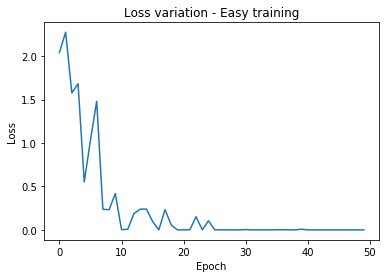

In [23]:
import matplotlib.pyplot as plt

#joli plot du loss en fonction de l'epoch

plt.plot(tempo, acc)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss variation - Easy training')
plt.savefig('mc16easy_sync_convo.png')
plt.show()

torch.save(model.state_dict(), "MODEL_convo_sync_16thetas")

Et maintenant on affiche les kernels :

Convolutional unsynced 
 Convolutional synced


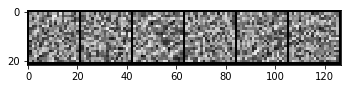

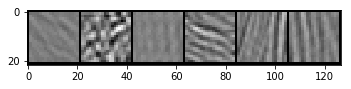

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torchvision import utils

def plotkernel(tensor, figname,ch=0, allkernels=True, nrow=8, padding=1):
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.savefig(figname)

convolayer = [i for i in model.children()][0]
kernel_unsync = convolayer.cpu()
kernel_unsync = convolayer.weight.data.clone()

convolayer2 = [i for i in model_sync.children()][0]
kernel_sync = convolayer2.cpu()
kernel_sync = convolayer2.weight.data.clone()


print("Convolutional unsynced \n Convolutional synced")
plotkernel(kernel_unsync, figname = 'kernel_unsyc.png')
plotkernel(kernel_sync, figname = 'kernel_sync.png')

# Lateral 

import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=16, shuffle=True,
                                             num_workers=1)

test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=16,shuffle=False,
                                             num_workers=1)

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            #forward
            self.fc1 = nn.Linear(64*64,1000)
            self.rec = nn.RNN(1000, hidden_size = 200,
                             num_layers=2, nonlinearity='relu',
                             batch_first = True)

        

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.rec(x)
            return F.log_softmax(input=x)
model = Net()
print(model)

import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

import time
start_time = time.time()
print("Started training")

epochs = 50
print_interval = 50 #prints every p_i*4
tempo = []
acc = []

for epoch in range(epochs):  # nbr epochs
    for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
        data, target = Variable(data), Variable(target)
        
        #On resize pour la sortie
        data = data.view(-1, 64*64)

        #init l'entrainement
        optimizer.zero_grad()
        net_out = model(data)

        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()

        #afficher la progression
        if batch_idx % print_interval == 0:
            #le print statement le plus illisible du monde
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    tempo.append(epoch)
    acc.append(loss.data[0])
    
print("Finished training in  %.3f seconds " % (time.time() - start_time))

import pickle
x = 3
pickle.dump(x, open('x.pkl', 'wb'))

import pickle
x = pickle.load( open('x.pkl', 'rb'))